# Hands-on Introduction to Generative AI

## Imports and constants

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets

from time import sleep
from IPython.display import display
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Generation vs Classification task

### Intro and data

In [3]:
X, y = make_moons(n_samples=1000, noise=0.2, random_state=RANDOM_SEED)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

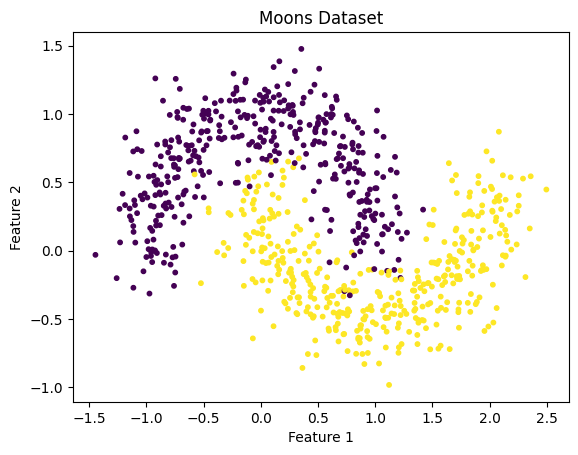

In [4]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Moons Dataset')
plt.show()

**Classification task**: $P(y|\mathbf{x})$ - ?

**Generation task**: $P(\mathbf{x}|y)$ - ?

### Simple classification network

In [5]:
class MoonsClassifier(nn.Module):
    def __init__(self):
        super(MoonsClassifier, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [6]:
clf = MoonsClassifier()
clf.train()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(clf.parameters(), lr=0.01)
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)
num_epochs = 100

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = clf(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    clf.eval()
    with torch.no_grad():
        outputs = clf(X_test_tensor)
        test_loss = criterion(outputs, y_test_tensor)
        outputs = (outputs > 0.5).float()
        accuracy = ((outputs == y_test_tensor).sum().item()) / y_test_tensor.size(0)

    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}, Accuracy: {accuracy:.4f}')


Epoch [1], Loss: 0.6890, Test Loss: 0.6820, Accuracy: 0.5000
Epoch [2], Loss: 0.6802, Test Loss: 0.6742, Accuracy: 0.5000
Epoch [3], Loss: 0.6713, Test Loss: 0.6663, Accuracy: 0.5000
Epoch [4], Loss: 0.6622, Test Loss: 0.6578, Accuracy: 0.5000
Epoch [5], Loss: 0.6526, Test Loss: 0.6487, Accuracy: 0.5000
Epoch [6], Loss: 0.6423, Test Loss: 0.6389, Accuracy: 0.5000
Epoch [7], Loss: 0.6311, Test Loss: 0.6282, Accuracy: 0.5000
Epoch [8], Loss: 0.6193, Test Loss: 0.6167, Accuracy: 0.5650
Epoch [9], Loss: 0.6066, Test Loss: 0.6046, Accuracy: 0.7150
Epoch [10], Loss: 0.5933, Test Loss: 0.5918, Accuracy: 0.7550
Epoch [11], Loss: 0.5794, Test Loss: 0.5784, Accuracy: 0.7450
Epoch [12], Loss: 0.5648, Test Loss: 0.5643, Accuracy: 0.7600
Epoch [13], Loss: 0.5498, Test Loss: 0.5497, Accuracy: 0.7550
Epoch [14], Loss: 0.5343, Test Loss: 0.5345, Accuracy: 0.7600
Epoch [15], Loss: 0.5185, Test Loss: 0.5190, Accuracy: 0.7500
Epoch [16], Loss: 0.5025, Test Loss: 0.5032, Accuracy: 0.7750
Epoch [17], Loss:

Visualize the decision boundary:

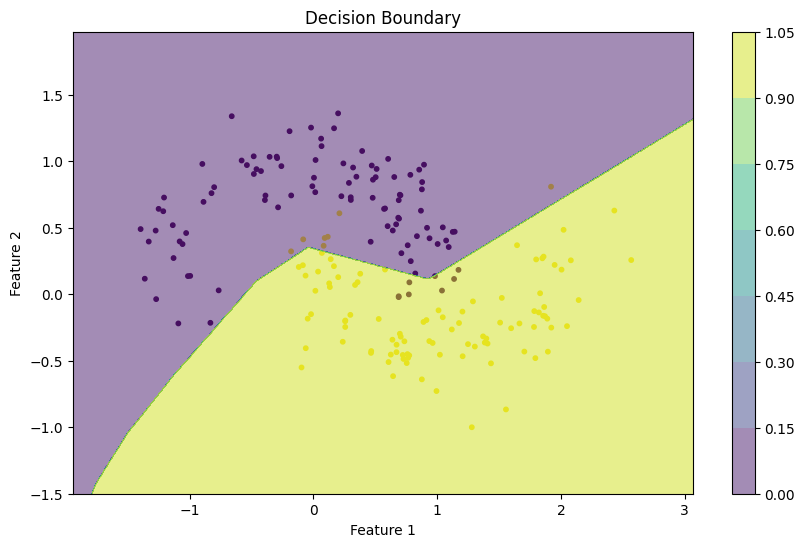

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=10, cmap='viridis')
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.005),
                     np.arange(y_min, y_max, 0.005))
with torch.no_grad():
    Z = clf(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.squeeze().numpy()
Z = (Z > 0.5).astype(int)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.5, cmap='viridis')
plt.title('Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar()
plt.show()

### Simple generative network

Let's reverse the network:

In [8]:
class MoonsGenerator1(nn.Module):
    def __init__(self):
        super(MoonsGenerator1, self).__init__()
        self.fc1 = nn.Linear(1, 8)
        self.fc2 = nn.Linear(8, 16)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
gen = MoonsGenerator1()
gen.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gen.parameters(), lr=0.01)
num_epochs = 100

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = gen(y_train_tensor)
    loss = criterion(outputs, X_train_tensor)
    loss.backward()
    optimizer.step()

    clf.eval()
    with torch.no_grad():
        outputs = gen(y_test_tensor)
        test_loss = criterion(outputs, X_test_tensor)
    
    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')


Epoch [1], Loss: 0.6291, Test Loss: 0.5851
Epoch [2], Loss: 0.5961, Test Loss: 0.5535
Epoch [3], Loss: 0.5665, Test Loss: 0.5256
Epoch [4], Loss: 0.5405, Test Loss: 0.5018
Epoch [5], Loss: 0.5186, Test Loss: 0.4827
Epoch [6], Loss: 0.5013, Test Loss: 0.4681
Epoch [7], Loss: 0.4884, Test Loss: 0.4578
Epoch [8], Loss: 0.4797, Test Loss: 0.4513
Epoch [9], Loss: 0.4744, Test Loss: 0.4469
Epoch [10], Loss: 0.4709, Test Loss: 0.4428
Epoch [11], Loss: 0.4673, Test Loss: 0.4375
Epoch [12], Loss: 0.4621, Test Loss: 0.4304
Epoch [13], Loss: 0.4546, Test Loss: 0.4217
Epoch [14], Loss: 0.4452, Test Loss: 0.4126
Epoch [15], Loss: 0.4350, Test Loss: 0.4027
Epoch [16], Loss: 0.4237, Test Loss: 0.3930
Epoch [17], Loss: 0.4124, Test Loss: 0.3837
Epoch [18], Loss: 0.4014, Test Loss: 0.3754
Epoch [19], Loss: 0.3912, Test Loss: 0.3680
Epoch [20], Loss: 0.3817, Test Loss: 0.3617
Epoch [21], Loss: 0.3735, Test Loss: 0.3564
Epoch [22], Loss: 0.3661, Test Loss: 0.3520
Epoch [23], Loss: 0.3596, Test Loss: 0.34

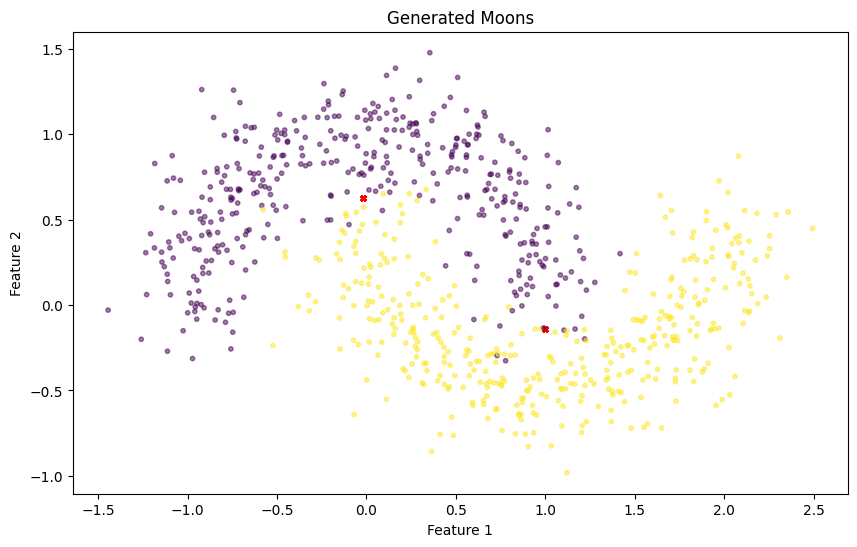

In [10]:
upper_moon_gen = gen(torch.FloatTensor([[1.0]] * 100))
lower_moon_gen = gen(torch.FloatTensor([[0.0]] * 100))
X_gen = torch.cat((upper_moon_gen, lower_moon_gen), dim=0).detach().numpy()
y_gen = np.concatenate((np.ones(100), np.zeros(100)), axis=0)
plt.figure(figsize=(10, 6))
plt.scatter(X_gen[:, 0], X_gen[:, 1], s=10, marker="x", c='red')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.5)
plt.title('Generated Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

NN is determenistic $\rightarrow$ single result

In [11]:
class MoonsGenerator2(nn.Module):
    def __init__(self):
        super(MoonsGenerator2, self).__init__()
        self.fc1 = nn.Linear(2, 8)
        self.fc2 = nn.Linear(8, 16)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
gen = MoonsGenerator2()
gen.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gen.parameters(), lr=0.01)
num_epochs = 100

for epoch in range(num_epochs):
    optimizer.zero_grad()
    train_noise = torch.randn(X_train_tensor.size(0), 1)
    y_train_tensor_ = torch.cat((y_train_tensor, train_noise), dim=1)
    outputs = gen(y_train_tensor_)
    loss = criterion(outputs, X_train_tensor)
    loss.backward()
    optimizer.step()

    clf.eval()
    with torch.no_grad():
        test_noise = torch.randn(X_test_tensor.size(0), 1)
        y_test_tensor_ = torch.cat((y_test_tensor, test_noise), dim=1)
        outputs = gen(y_test_tensor_)
        test_loss = criterion(outputs, X_test_tensor)
    
    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')


Epoch [1], Loss: 0.7782, Test Loss: 0.7379
Epoch [2], Loss: 0.7392, Test Loss: 0.6977
Epoch [3], Loss: 0.7036, Test Loss: 0.6671
Epoch [4], Loss: 0.6728, Test Loss: 0.6362
Epoch [5], Loss: 0.6451, Test Loss: 0.6102
Epoch [6], Loss: 0.6213, Test Loss: 0.5810
Epoch [7], Loss: 0.5990, Test Loss: 0.5661
Epoch [8], Loss: 0.5783, Test Loss: 0.5461
Epoch [9], Loss: 0.5610, Test Loss: 0.5299
Epoch [10], Loss: 0.5485, Test Loss: 0.5139
Epoch [11], Loss: 0.5376, Test Loss: 0.5029
Epoch [12], Loss: 0.5258, Test Loss: 0.4991
Epoch [13], Loss: 0.5151, Test Loss: 0.4867
Epoch [14], Loss: 0.5107, Test Loss: 0.4739
Epoch [15], Loss: 0.5032, Test Loss: 0.4688
Epoch [16], Loss: 0.4986, Test Loss: 0.4647
Epoch [17], Loss: 0.4864, Test Loss: 0.4581
Epoch [18], Loss: 0.4782, Test Loss: 0.4494
Epoch [19], Loss: 0.4698, Test Loss: 0.4332
Epoch [20], Loss: 0.4582, Test Loss: 0.4272
Epoch [21], Loss: 0.4479, Test Loss: 0.4154
Epoch [22], Loss: 0.4345, Test Loss: 0.4049
Epoch [23], Loss: 0.4239, Test Loss: 0.39

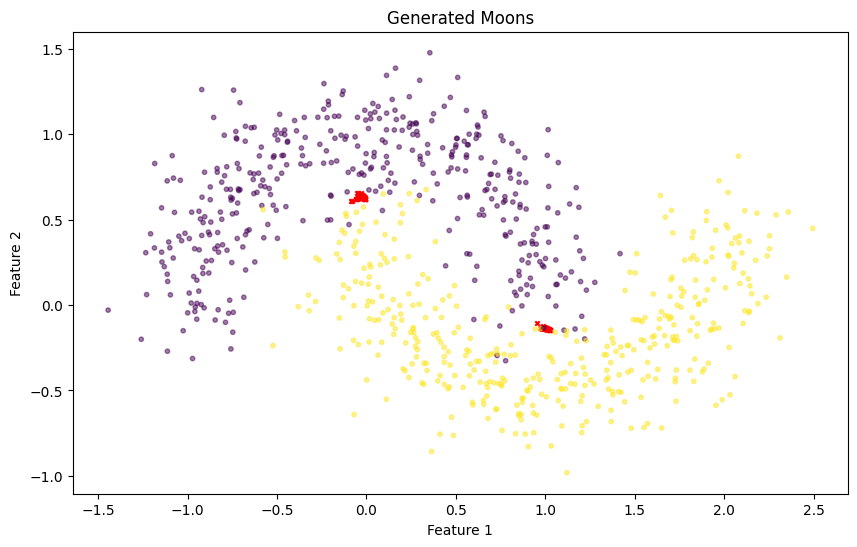

In [13]:
gen_input = torch.cat((torch.cat((torch.FloatTensor([[1.0]] * 100), torch.FloatTensor([[0.0]] * 100)), dim=0), torch.randn(200, 1)), dim=1)
with torch.no_grad():
    X_gen = gen(gen_input)
X_gen = X_gen.detach().numpy()
plt.figure(figsize=(10, 6))
plt.scatter(X_gen[:, 0], X_gen[:, 1], s=10, marker="x", c='red')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.5)
plt.title('Generated Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## Generative tasks in a nutshell

![](./assets/generative1.png)

> <font color="red">**TODO:**</font> Implement histogram-based generation (for 2 moons).

Problem: complex shape manifold

![](./assets/generative2.png)

Solution: learn mapping to this manifold from the known

![](./assets/generative3.png)

### Common CV generative methods

![](./assets/cv_gen_methods.png)

## Autoencoder

In [14]:
class MoonAutoencoder(nn.Module):
    def __init__(self):
        super(MoonAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def forward(self, x):
        latent = self.encoder(x)
        x_reconst = self.decoder(latent)
        return x_reconst
    
    def generate(self, latent):
        x_reconst = self.decoder(latent)
        return x_reconst

In [15]:
autoenc = MoonAutoencoder()
autoenc.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoenc.parameters(), lr=0.01)
num_epochs = 100

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = autoenc(X_train_tensor)
    loss = criterion(outputs, X_train_tensor)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        outputs = autoenc(X_test_tensor)
        test_loss = criterion(outputs, X_test_tensor)
    
    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

Epoch [1], Loss: 0.6984, Test Loss: 0.6584
Epoch [2], Loss: 0.6672, Test Loss: 0.6284
Epoch [3], Loss: 0.6390, Test Loss: 0.6017
Epoch [4], Loss: 0.6141, Test Loss: 0.5786
Epoch [5], Loss: 0.5929, Test Loss: 0.5589
Epoch [6], Loss: 0.5752, Test Loss: 0.5422
Epoch [7], Loss: 0.5607, Test Loss: 0.5283
Epoch [8], Loss: 0.5491, Test Loss: 0.5176
Epoch [9], Loss: 0.5407, Test Loss: 0.5101
Epoch [10], Loss: 0.5355, Test Loss: 0.5059
Epoch [11], Loss: 0.5333, Test Loss: 0.5041
Epoch [12], Loss: 0.5334, Test Loss: 0.5037
Epoch [13], Loss: 0.5345, Test Loss: 0.5030
Epoch [14], Loss: 0.5348, Test Loss: 0.5007
Epoch [15], Loss: 0.5330, Test Loss: 0.4959
Epoch [16], Loss: 0.5282, Test Loss: 0.4885
Epoch [17], Loss: 0.5202, Test Loss: 0.4788
Epoch [18], Loss: 0.5095, Test Loss: 0.4701
Epoch [19], Loss: 0.4984, Test Loss: 0.4626
Epoch [20], Loss: 0.4891, Test Loss: 0.4548
Epoch [21], Loss: 0.4800, Test Loss: 0.4472
Epoch [22], Loss: 0.4710, Test Loss: 0.4390
Epoch [23], Loss: 0.4614, Test Loss: 0.43

In [16]:
gen_input = torch.randn(100, 1) # torch.arange(-5, 5, 0.1).view(-1, 1)
with torch.no_grad():
    X_gen = autoenc.generate(gen_input)
X_gen = X_gen.detach().numpy()

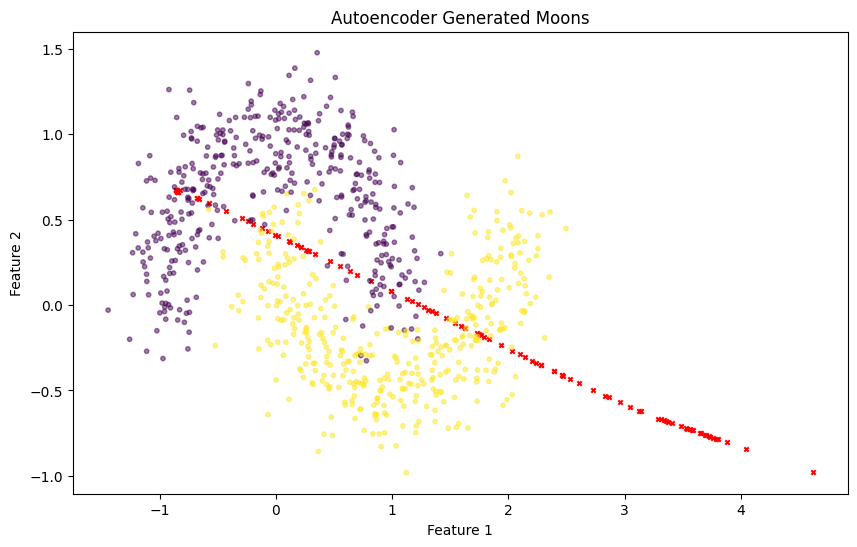

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(X_gen[:, 0], X_gen[:, 1], s=10, marker="x", c='red')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.5)
plt.title('Autoencoder Generated Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [19]:
class MoonConditionalAutoencoder(nn.Module):
    def __init__(self):
        super(MoonConditionalAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )
        self.embedding = nn.Embedding(2, 1)

    def forward(self, x, y):
        latent = self.encoder(x)
        y = self.embedding(y)[:, 0]
        x_reconst = self.decoder(torch.cat((latent, y), dim=1))
        return x_reconst
    
    def generate(self, latent, y):
        y = self.embedding(y)[:, 0]
        x_reconst = self.decoder(torch.cat((latent, y), dim=1))
        return x_reconst

In [20]:
autoenc_cond = MoonConditionalAutoencoder()
autoenc_cond.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoenc_cond.parameters(), lr=0.01)
num_epochs = 1000

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = autoenc_cond(X_train_tensor, y_train_tensor.to(torch.long))
    loss = criterion(outputs, X_train_tensor)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        outputs = autoenc_cond(X_test_tensor, y_test_tensor.to(torch.long))
        test_loss = criterion(outputs, X_test_tensor)
    
    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

Epoch [1], Loss: 0.7666, Test Loss: 0.7302
Epoch [2], Loss: 0.7330, Test Loss: 0.6973
Epoch [3], Loss: 0.7015, Test Loss: 0.6664
Epoch [4], Loss: 0.6718, Test Loss: 0.6368
Epoch [5], Loss: 0.6433, Test Loss: 0.6080
Epoch [6], Loss: 0.6157, Test Loss: 0.5800
Epoch [7], Loss: 0.5886, Test Loss: 0.5524
Epoch [8], Loss: 0.5619, Test Loss: 0.5247
Epoch [9], Loss: 0.5352, Test Loss: 0.4966
Epoch [10], Loss: 0.5078, Test Loss: 0.4679
Epoch [11], Loss: 0.4796, Test Loss: 0.4386
Epoch [12], Loss: 0.4507, Test Loss: 0.4085
Epoch [13], Loss: 0.4209, Test Loss: 0.3767
Epoch [14], Loss: 0.3894, Test Loss: 0.3450
Epoch [15], Loss: 0.3568, Test Loss: 0.3164
Epoch [16], Loss: 0.3273, Test Loss: 0.2910
Epoch [17], Loss: 0.3009, Test Loss: 0.2692
Epoch [18], Loss: 0.2782, Test Loss: 0.2526
Epoch [19], Loss: 0.2607, Test Loss: 0.2422
Epoch [20], Loss: 0.2495, Test Loss: 0.2383
Epoch [21], Loss: 0.2447, Test Loss: 0.2378
Epoch [22], Loss: 0.2436, Test Loss: 0.2349
Epoch [23], Loss: 0.2404, Test Loss: 0.22

In [21]:
gen_input = torch.randn(200, 1) # torch.arange(-10, 10, 0.1).view(-1, 1)
y_gen = torch.cat((torch.LongTensor([[1]] * len(gen_input)), torch.LongTensor([[0]] * len(gen_input))), dim=0)
with torch.no_grad():
    X_gen = autoenc_cond.generate(gen_input.repeat(2, 1), y_gen)
X_gen = X_gen.detach().numpy()

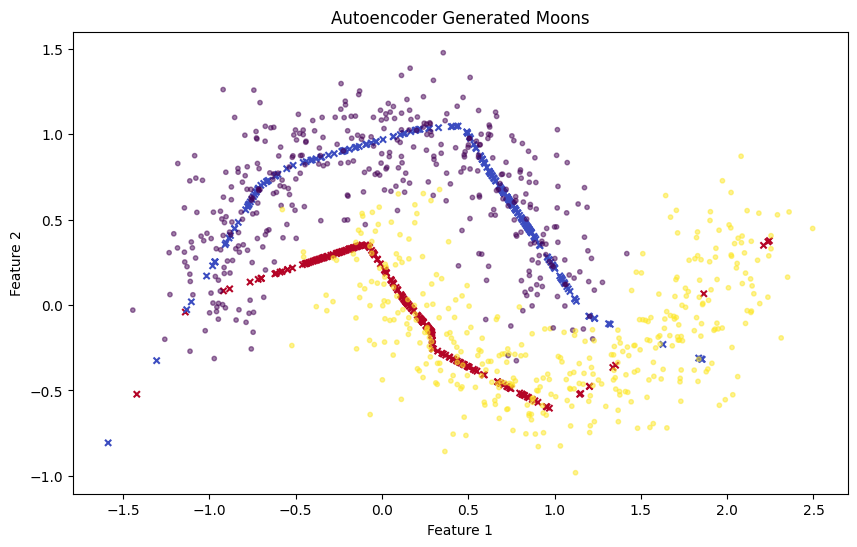

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(X_gen[:, 0], X_gen[:, 1], s=20, marker="x", cmap='coolwarm', c=y_gen)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.5)
plt.title('Autoencoder Generated Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

Autoencoder cons (as a generative model):
- Unregularized, possibly discontinuous latent space
- Chaotic (unspecified) distribution
- Less samples diversity

## Variational autoencoder (VAE)

![](./assets/VAE.jpg)

More details [here](https://medium.com/geekculture/variational-autoencoder-vae-9b8ce5475f68).

KL divergence loss full derivation is [here](https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes/370048#370048).

In [23]:
class MoonVAE(nn.Module):
    def __init__(self):
        super(MoonVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        enc_out = self.encoder(x)
        mu = enc_out[:, 0].unsqueeze(1)
        logvar = enc_out[:, 1].unsqueeze(1)
        
        z = self.reparameterize(mu, logvar)
        x_reconst = self.decoder(z)
        return x_reconst, mu, logvar
    
    def generate(self, z):
        x_reconst = self.decoder(z)
        return x_reconst

In [24]:
vae = MoonVAE()
vae.train()

reconstruction_criterion = nn.MSELoss()
kl_weight = 0.0001
optimizer = torch.optim.Adam(vae.parameters(), lr=0.01)
num_epochs = 1000

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs, mu, logvar = vae(X_train_tensor)
    reconstruction_loss = reconstruction_criterion(outputs, X_train_tensor)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = reconstruction_loss + kl_weight * kl_loss
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        outputs, mu, logvar = vae(X_test_tensor)
        test_reconstruction_loss = reconstruction_criterion(outputs, X_test_tensor)
        test_kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Reconstruction Loss: {test_reconstruction_loss.item():.4f}, Test KL Loss: {test_kl_loss.item():.4f}')

Epoch [1], Loss: 0.5764, Test Reconstruction Loss: 0.5519, Test KL Loss: 13.3269
Epoch [2], Loss: 0.5732, Test Reconstruction Loss: 0.5399, Test KL Loss: 11.6983
Epoch [3], Loss: 0.5634, Test Reconstruction Loss: 0.5278, Test KL Loss: 10.3520
Epoch [4], Loss: 0.5558, Test Reconstruction Loss: 0.5306, Test KL Loss: 9.1984
Epoch [5], Loss: 0.5500, Test Reconstruction Loss: 0.5247, Test KL Loss: 8.2282
Epoch [6], Loss: 0.5495, Test Reconstruction Loss: 0.5189, Test KL Loss: 7.4576
Epoch [7], Loss: 0.5489, Test Reconstruction Loss: 0.5100, Test KL Loss: 6.8303
Epoch [8], Loss: 0.5413, Test Reconstruction Loss: 0.5185, Test KL Loss: 6.3286
Epoch [9], Loss: 0.5410, Test Reconstruction Loss: 0.5092, Test KL Loss: 5.9220
Epoch [10], Loss: 0.5513, Test Reconstruction Loss: 0.5184, Test KL Loss: 5.6124
Epoch [11], Loss: 0.5466, Test Reconstruction Loss: 0.5140, Test KL Loss: 5.3708
Epoch [12], Loss: 0.5476, Test Reconstruction Loss: 0.5179, Test KL Loss: 5.1874
Epoch [13], Loss: 0.5445, Test Rec

In [25]:
gen_input = torch.randn(200, 1) # torch.arange(-10, 10, 0.1).view(-1, 1)
with torch.no_grad():
    X_gen = vae.generate(gen_input)
X_gen = X_gen.detach().numpy()

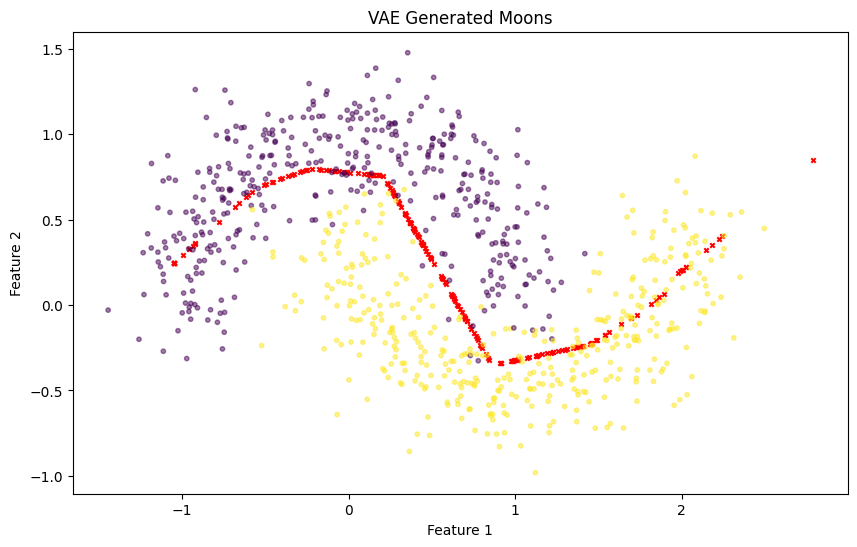

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(X_gen[:, 0], X_gen[:, 1], s=10, marker="x", c='red')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.5)
plt.title('VAE Generated Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [27]:
enc_out = vae.encoder(X_test_tensor)
mu = enc_out[:, 0].unsqueeze(1)
logvar = enc_out[:, 1].unsqueeze(1)

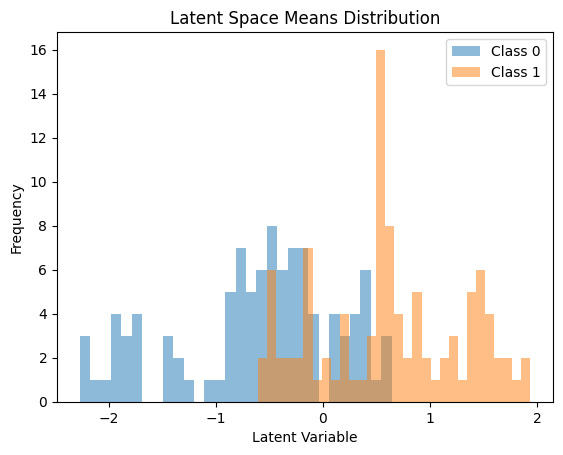

In [28]:
plt.hist(mu[y_test_tensor == 0].detach().numpy(), bins=30, alpha=0.5, label='Class 0')
plt.hist(mu[y_test_tensor == 1].detach().numpy(), bins=30, alpha=0.5, label='Class 1')
plt.title('Latent Space Means Distribution')
plt.xlabel('Latent Variable')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [29]:
class MoonVAEConditional(nn.Module):
    def __init__(self):
        super(MoonVAEConditional, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )
        self.embedding = nn.Embedding(2, 1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        enc_out = self.encoder(x)
        mu = enc_out[:, 0].unsqueeze(1)
        logvar = enc_out[:, 1].unsqueeze(1)
        
        z = self.reparameterize(mu, logvar)
        y = self.embedding(y)[:, 0]
        z = torch.cat((z, y), dim=1)

        x_reconst = self.decoder(z)
        return x_reconst, mu, logvar
    
    def generate(self, z, y):
        y = self.embedding(y)[:, 0]
        z = torch.cat((z, y), dim=1)
        x_reconst = self.decoder(z)
        return x_reconst

In [30]:
vae_cond = MoonVAEConditional()
vae_cond.train()

reconstruction_criterion = nn.MSELoss()
kl_weight = 0.0001
optimizer = torch.optim.Adam(vae_cond.parameters(), lr=0.01)
num_epochs = 1000

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs, mu, logvar = vae_cond(X_train_tensor, y_train_tensor.to(torch.long))
    reconstruction_loss = reconstruction_criterion(outputs, X_train_tensor)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = reconstruction_loss + kl_weight * kl_loss
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        outputs, mu, logvar = vae_cond(X_test_tensor, y_test_tensor.to(torch.long))
        test_reconstruction_loss = reconstruction_criterion(outputs, X_test_tensor)
        test_kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Reconstruction Loss: {test_reconstruction_loss.item():.4f}, Test KL Loss: {test_kl_loss.item():.4f}')

Epoch [1], Loss: 0.7991, Test Reconstruction Loss: 0.7372, Test KL Loss: 38.2722
Epoch [2], Loss: 0.7579, Test Reconstruction Loss: 0.7081, Test KL Loss: 32.7638
Epoch [3], Loss: 0.7242, Test Reconstruction Loss: 0.6774, Test KL Loss: 28.2217
Epoch [4], Loss: 0.6956, Test Reconstruction Loss: 0.6551, Test KL Loss: 24.1875
Epoch [5], Loss: 0.6725, Test Reconstruction Loss: 0.6367, Test KL Loss: 20.5752
Epoch [6], Loss: 0.6544, Test Reconstruction Loss: 0.6140, Test KL Loss: 17.3139
Epoch [7], Loss: 0.6322, Test Reconstruction Loss: 0.5948, Test KL Loss: 14.3962
Epoch [8], Loss: 0.6208, Test Reconstruction Loss: 0.5878, Test KL Loss: 11.8374
Epoch [9], Loss: 0.6048, Test Reconstruction Loss: 0.5752, Test KL Loss: 9.6178
Epoch [10], Loss: 0.5914, Test Reconstruction Loss: 0.5628, Test KL Loss: 7.7174
Epoch [11], Loss: 0.5856, Test Reconstruction Loss: 0.5463, Test KL Loss: 6.1102
Epoch [12], Loss: 0.5779, Test Reconstruction Loss: 0.5509, Test KL Loss: 4.7780
Epoch [13], Loss: 0.5708, Tes

In [33]:
gen_input = torch.randn(200, 1) # torch.arange(-20, 20, 0.1).view(-1, 1) # torch.randn(200, 1)
y_gen = torch.cat((torch.LongTensor([[1]] * len(gen_input)), torch.LongTensor([[0]] * len(gen_input))), dim=0)
with torch.no_grad():
    X_gen = vae_cond.generate(gen_input.repeat(2, 1), y_gen)
X_gen = X_gen.detach().numpy()

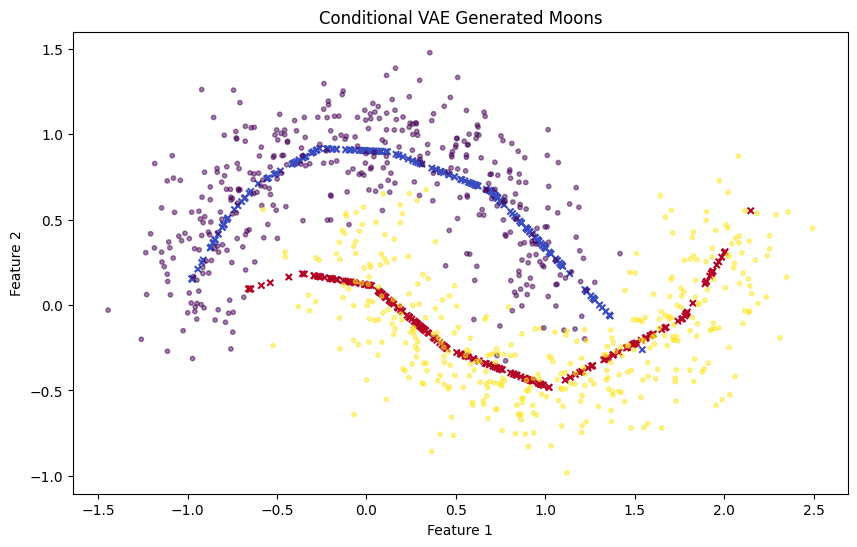

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(X_gen[:, 0], X_gen[:, 1], s=20, marker="x", c=y_gen, cmap='coolwarm')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.5)
plt.title('Conditional VAE Generated Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## Diffusion

![](./assets/diffusion.png)

Diffusion can be formalized as a fixed Markov chain with T steps. Each step depends only on the previous one, allowing us to derive a closed-form formula to obtain the corrupted image at any desired timestep, bypassing the need for iterative computation.

Diffusion process can be described like that:

$x_t = \sqrt{1-\beta_t} x_{t-1} + \sqrt{\beta_t} z_t$

$z_t \sim N(0, 1)$

Reparametrizing:

$\alpha_t = 1 - \beta_t$

$\bar{\alpha_t} = \alpha_1 \cdot ... \cdot \alpha_t$

$x_t|x_0 \sim N(\sqrt{\bar{\alpha_t}}x_0, (1 - \bar{\alpha_t})I)$

$\tilde\mu_t(x_t, x_0) = \frac{\sqrt{\alpha_t}(1 - \bar\alpha_{t-1})x_t + \sqrt{\bar{\alpha_{t-1}}}(1-\alpha_t)x_0}{1 - \bar{\alpha_t}}$

$x_{t-1}|x_0,x_t \sim N(\tilde\mu_t(x_t, x_0), (1 - \bar{\alpha_t})I)$

$x_t = \sqrt{\bar{\alpha_t}}x_0 + \sqrt{1 - \bar{\alpha_t}} z$

$x_0 = \frac{x_t - \sqrt{1 - \bar{\alpha_t}} z}{\sqrt{\bar{\alpha_t}}}$

Network: $\epsilon_\Theta(x_t, t)$

$x_{t-1}|x_t \sim N(\tilde\mu_t(x_t, \frac{x_t - \sqrt{1 - \bar{\alpha_t}} \epsilon_\Theta(x_t, t)}{\sqrt{\bar{\alpha_t}}}), (1 - \bar{\alpha_t})I)$

$x_{t-1}|x_t \sim N(\frac{x_t - \epsilon_\Theta(x_t, t)\beta_t/\sqrt{1 - \bar\alpha_t}}{\sqrt{\alpha_t}}, (1 - \bar{\alpha_t})I)$

Longer explanation and derivation [here](https://en.wikipedia.org/wiki/Diffusion_model).

Schedulers:

![](./assets/schedulers.png)



In [35]:
class MoonsUNet(nn.Module):
    def __init__(self, num_timesteps=100, time_emb_dim=2):
        super(MoonsUNet, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Linear(2 + time_emb_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
        )
        self.encoder2 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(8 + time_emb_dim, 4),
            nn.ReLU(),
            nn.Linear(4, 4),
        )
        self.bottleneck = nn.Sequential(
            nn.ReLU(),
            nn.Linear(4 + time_emb_dim, 2),
            nn.ReLU(),
            nn.Linear(2, 4),
        )
        self.decoder1 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
        )
        self.decoder2 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2),
        )
        self.num_timesteps = num_timesteps
        self.time_embedding = nn.Embedding(num_timesteps, time_emb_dim)

    def forward(self, x, t):
        t_emb = self.time_embedding(t)[:, 0]
        x = torch.cat((x, t_emb), dim=1)
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(torch.cat((enc1, t_emb), dim=1))
        bottleneck = self.bottleneck(torch.cat((enc2, t_emb), dim=1))
        dec1 = self.decoder1(torch.cat((bottleneck, enc2), dim=1))
        dec2 = self.decoder2(torch.cat((dec1, enc1), dim=1))
        return dec2

In [36]:
num_epochs = 1000
num_timesteps = 100

unet = MoonsUNet(num_timesteps=num_timesteps, time_emb_dim=2)
unet.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=0.01)

In [80]:
def linear_schedule(t, timesteps, beta1=1e-3, beta2=0.2):
    return (beta2 - beta1) * t / timesteps + beta1

def cosine_schedule(t, timesteps, s=0.008):
    alpha_hat = np.cos(np.pi/2*(t / timesteps + s)/(1 + s))**2
    alpha_hat_prev = np.cos(np.pi/2*((t-1) / timesteps + s)/(1 + s))**2
    beta = 1 - alpha_hat/alpha_hat_prev
    beta = torch.clip(beta, None, 0.999)
    return beta

linear_betas = linear_schedule(torch.arange(num_timesteps), num_timesteps)
cosine_betas = cosine_schedule(torch.arange(num_timesteps), num_timesteps)

linear_alphas = 1 - linear_betas
cosine_alphas = 1 - cosine_betas

linear_alphas_cumprod = torch.cumprod(linear_alphas, dim=0)
cosine_alphas_cumprod = torch.cumprod(cosine_alphas, dim=0)
linear_alphas_cumprod_prev = torch.cat((torch.tensor([1.0]), linear_alphas_cumprod[:-1]), dim=0)
cosine_alphas_cumprod_prev = torch.cat((torch.tensor([1.0]), cosine_alphas_cumprod[:-1]), dim=0)

def apply_diffusion(X, t, schedule):
    noise = torch.randn_like(X)
    if schedule == "Linear":
        alpha_hat = linear_alphas_cumprod[t]
    elif schedule == "Cosine":
        alpha_hat = cosine_alphas_cumprod[t]

    return alpha_hat.sqrt() * X + (1 - alpha_hat).sqrt() * noise, noise

def update_plot(*args):
    with output:
        output.clear_output(wait=True)
        
        schedule = dropdown_schedule.value
        X_noisy, _ = apply_diffusion(X_train_tensor, slider_timesteps.value, schedule)
        
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.scatter(X_noisy[:, 0], X_noisy[:, 1], c=y_train, s=10, cmap='viridis')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.set_title('Moons Dataset with Diffusion')
        ax.set_xlim(-2, 2)
        ax.set_ylim(-1.5, 1.5)
        
        display(fig)
        plt.close(fig)

slider_timesteps = widgets.IntSlider(min=1, max=num_timesteps-1, step=1, value=1, description="Timesteps")
dropdown_schedule = widgets.Dropdown(options=["Linear", "Cosine"], value="Linear", description="Schedule")
output = widgets.Output()

slider_timesteps.observe(update_plot, names='value')
dropdown_schedule.observe(update_plot, names='value')

display(slider_timesteps, dropdown_schedule, output)
update_plot()

IntSlider(value=1, description='Timesteps', max=99, min=1)

Dropdown(description='Schedule', options=('Linear', 'Cosine'), value='Linear')

Output()

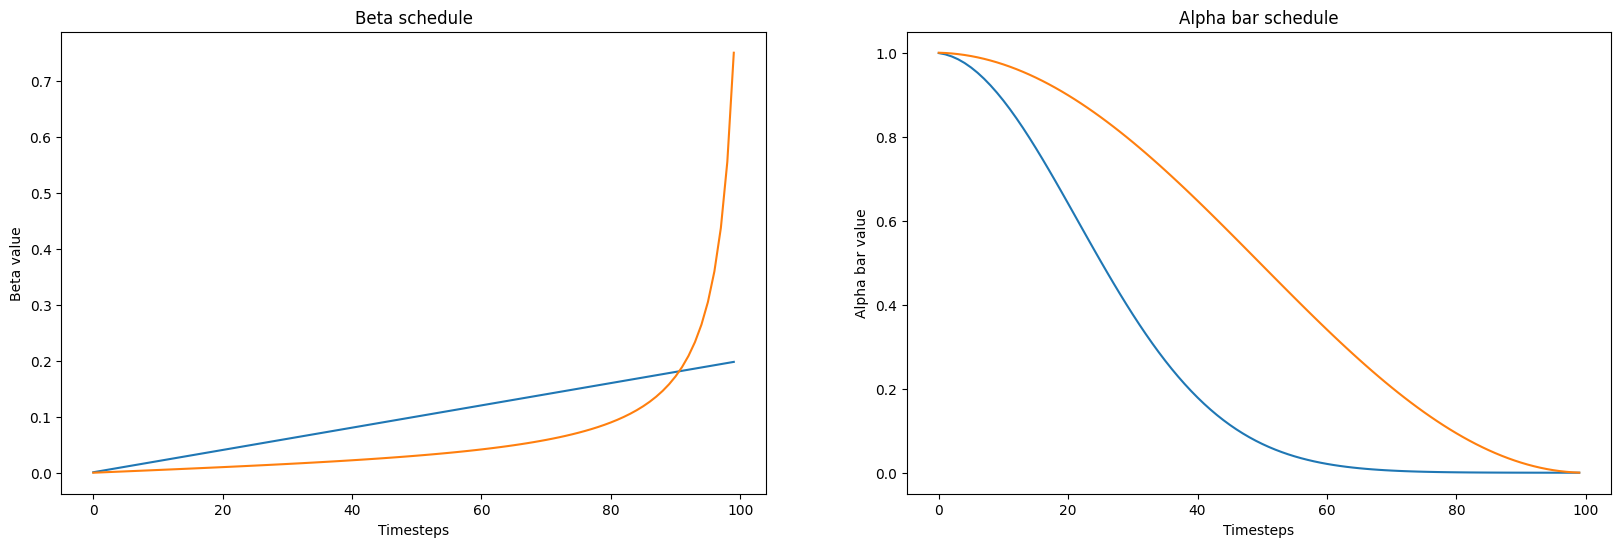

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

axs[0].plot(linear_betas, label="Linear")
axs[0].plot(cosine_betas, label="Cosine")
axs[0].set_xlabel("Timesteps")
axs[0].set_ylabel("Beta value")
axs[0].set_title("Beta schedule")

axs[1].plot(linear_alphas_cumprod, label="Linear")
axs[1].plot(cosine_alphas_cumprod, label="Cosine")
axs[1].set_xlabel("Timesteps")
axs[1].set_ylabel("Alpha bar value")
axs[1].set_title("Alpha bar schedule")
plt.show()

In [85]:
chosen_schedule = "Linear"

for epoch in range(num_epochs):
    unet.train()
    timesteps = torch.randint(0, num_timesteps, (X_train_tensor.size(0), 1))

    optimizer.zero_grad()
    noisy_X, noise = apply_diffusion(X_train_tensor, timesteps, chosen_schedule)
    noisy_X = noisy_X.float()
    outputs = unet(noisy_X, timesteps)
    loss = criterion(outputs, noise)
    
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        unet.eval()
        timesteps = torch.randint(0, num_timesteps, (X_test_tensor.size(0), 1))
        noisy_X, noise = apply_diffusion(X_test_tensor, timesteps, chosen_schedule)
        outputs = unet(noisy_X, timesteps)
        test_loss = criterion(outputs, noise)

    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')


Epoch [1], Loss: -0.6164, Test Loss: -0.6161
Epoch [2], Loss: -0.7788, Test Loss: -0.6290
Epoch [3], Loss: -0.5512, Test Loss: -0.5949
Epoch [4], Loss: -0.5608, Test Loss: -0.7466
Epoch [5], Loss: -0.5349, Test Loss: -0.7851
Epoch [6], Loss: -0.6618, Test Loss: -0.7226
Epoch [7], Loss: -0.7274, Test Loss: -0.9295
Epoch [8], Loss: -0.7852, Test Loss: -0.8327
Epoch [9], Loss: -0.6472, Test Loss: -0.8813
Epoch [10], Loss: -0.7992, Test Loss: -0.5021
Epoch [11], Loss: -0.6796, Test Loss: -0.5243
Epoch [12], Loss: -0.7187, Test Loss: -0.4930
Epoch [13], Loss: -0.5927, Test Loss: -0.5459
Epoch [14], Loss: -0.7334, Test Loss: -0.5113
Epoch [15], Loss: -0.6582, Test Loss: -0.6639
Epoch [16], Loss: -0.5915, Test Loss: -0.9816
Epoch [17], Loss: -0.7301, Test Loss: -0.7027
Epoch [18], Loss: -0.6689, Test Loss: -0.7720
Epoch [19], Loss: -0.6775, Test Loss: -0.7337
Epoch [20], Loss: -0.6440, Test Loss: -0.4196
Epoch [21], Loss: -0.6367, Test Loss: -0.7738
Epoch [22], Loss: -0.5781, Test Loss: -0.87

DDPM scheduling:

In [86]:
samples = 1000

X_gen = torch.randn(samples, 2)
X_gen_samples = []
for t in reversed(range(num_timesteps)):
    t_tensor = torch.full((samples, 1), t)
    pred_noise = unet(X_gen, t_tensor)
    noise = torch.randn_like(X_gen)

    beta_t = linear_betas[t] if chosen_schedule == "Linear" else cosine_betas[t]
    alpha_hat_t = linear_alphas_cumprod[t] if chosen_schedule == "Linear" else cosine_alphas_cumprod[t]
    
    if t > 0:
        X_gen = (X_gen - pred_noise * beta_t / (1 - alpha_hat_t).sqrt()) / (1 - beta_t).sqrt() + noise * beta_t.sqrt()
    else:
        X_gen = (X_gen - pred_noise * beta_t / (1 - alpha_hat_t).sqrt()) / (1 - beta_t).sqrt()
    X_gen_samples.append(X_gen.detach().numpy())
    
X_gen = X_gen.detach().numpy()

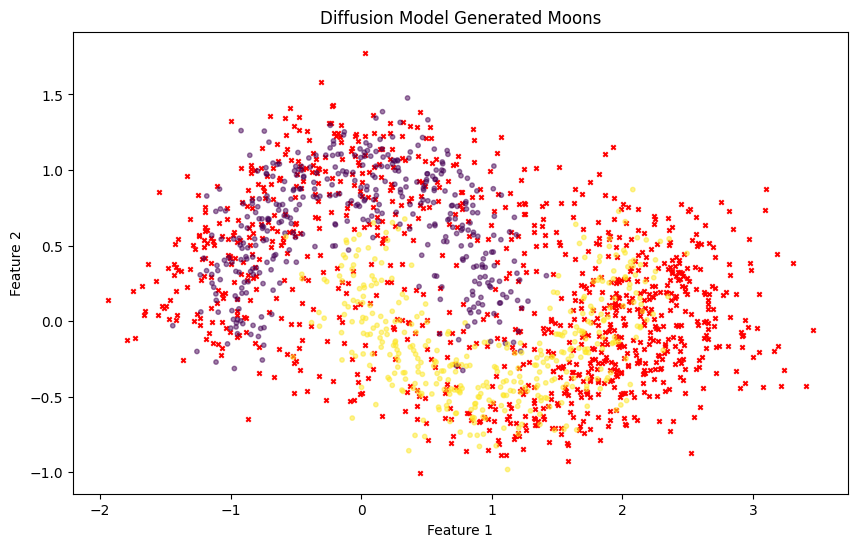

In [87]:
plt.figure(figsize=(10, 6))
plt.scatter(X_gen[:, 0], X_gen[:, 1], s=10, marker="x", c='red')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.5)
plt.title('Diffusion Model Generated Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [96]:
def update_plot(*args):
    with output:
        output.clear_output(wait=True)
        
        X_gen_chosen = X_gen_samples[num_timesteps - slider_timesteps.value]
        
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.scatter(X_gen_chosen[:, 0], X_gen_chosen[:, 1], s=10, marker="x", c='red')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.set_title(f'Generated Moons at timestep {slider_timesteps.value}')
        ax.set_xlim(-2, 3)
        ax.set_ylim(-1.5, 2)
        
        display(fig)
        plt.close(fig)

slider_timesteps = widgets.IntSlider(min=1, max=num_timesteps, step=1, value=num_timesteps, description="Timesteps")
output = widgets.Output()

slider_timesteps.observe(update_plot, names='value')

display(slider_timesteps, output)
update_plot()

IntSlider(value=100, description='Timesteps', min=1)

Output()

> **TODO**: Read about DDIM sampling.

In [89]:
class MoonsUNetConditional(nn.Module):
    def __init__(self, num_timesteps=100, time_emb_dim=2, class_emb_dim=2):
        super(MoonsUNetConditional, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Linear(2 + time_emb_dim + class_emb_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
        )
        self.encoder2 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(8 + time_emb_dim + class_emb_dim, 4),
            nn.ReLU(),
            nn.Linear(4, 4),
        )
        self.bottleneck = nn.Sequential(
            nn.ReLU(),
            nn.Linear(4 + time_emb_dim + class_emb_dim, 2),
            nn.ReLU(),
            nn.Linear(2, 4),
        )
        self.decoder1 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
        )
        self.decoder2 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2),
        )
        self.num_timesteps = num_timesteps
        self.time_embedding = nn.Embedding(num_timesteps, time_emb_dim)
        self.class_embedding = nn.Embedding(2, class_emb_dim)

    def forward(self, x, y, t):
        t_emb = self.time_embedding(t)[:, 0]
        y_emb = self.class_embedding(y)[:, 0]
        x = torch.cat((x, y_emb, t_emb), dim=1)
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(torch.cat((enc1, y_emb, t_emb), dim=1))
        bottleneck = self.bottleneck(torch.cat((enc2, y_emb, t_emb), dim=1))
        dec1 = self.decoder1(torch.cat((bottleneck, enc2), dim=1))
        dec2 = self.decoder2(torch.cat((dec1, enc1), dim=1))
        return dec2

In [90]:
num_epochs = 1000
num_timesteps = 100

unet_cond = MoonsUNetConditional(num_timesteps=num_timesteps, time_emb_dim=2, class_emb_dim=2)
unet_cond.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(unet_cond.parameters(), lr=0.01)

In [91]:
chosen_schedule = "Linear"

for epoch in range(num_epochs):
    unet_cond.train()
    timesteps = torch.randint(0, num_timesteps, (X_train_tensor.size(0), 1))

    optimizer.zero_grad()
    noisy_X, noise = apply_diffusion(X_train_tensor, timesteps, chosen_schedule)
    noisy_X = noisy_X.float()
    outputs = unet_cond(noisy_X, y_train_tensor.long(), timesteps)
    loss = criterion(outputs, noise)
    
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        unet_cond.eval()
        timesteps = torch.randint(0, num_timesteps, (X_test_tensor.size(0), 1))
        noisy_X, noise = apply_diffusion(X_test_tensor, timesteps, chosen_schedule)
        outputs = unet_cond(noisy_X, y_test_tensor.long(), timesteps)
        test_loss = criterion(outputs, noise)

    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')


Epoch [1], Loss: 1.0473, Test Loss: 0.9210
Epoch [2], Loss: 1.0318, Test Loss: 0.8707
Epoch [3], Loss: 0.9499, Test Loss: 0.9302
Epoch [4], Loss: 1.0254, Test Loss: 1.0468
Epoch [5], Loss: 0.9909, Test Loss: 1.0542
Epoch [6], Loss: 1.0356, Test Loss: 0.9720
Epoch [7], Loss: 0.9081, Test Loss: 0.9113
Epoch [8], Loss: 0.9034, Test Loss: 1.0539
Epoch [9], Loss: 0.9100, Test Loss: 1.0248
Epoch [10], Loss: 0.9550, Test Loss: 0.8894
Epoch [11], Loss: 0.9257, Test Loss: 0.8063
Epoch [12], Loss: 0.8662, Test Loss: 0.8490
Epoch [13], Loss: 0.8892, Test Loss: 0.8622
Epoch [14], Loss: 0.8434, Test Loss: 0.7784
Epoch [15], Loss: 0.7622, Test Loss: 0.7152
Epoch [16], Loss: 0.8208, Test Loss: 0.7487
Epoch [17], Loss: 0.7147, Test Loss: 0.7994
Epoch [18], Loss: 0.7158, Test Loss: 0.7145
Epoch [19], Loss: 0.6236, Test Loss: 0.6673
Epoch [20], Loss: 0.5846, Test Loss: 0.5069
Epoch [21], Loss: 0.5632, Test Loss: 0.5820
Epoch [22], Loss: 0.5596, Test Loss: 0.4273
Epoch [23], Loss: 0.4868, Test Loss: 0.41

In [92]:
samples = 1000

X_gen = torch.randn(samples, 2)
y_gen = torch.randint(0, 2, (samples, 1))
X_gen_samples = []
for t in reversed(range(num_timesteps)):
    t_tensor = torch.full((samples, 1), t)
    pred_noise = unet_cond(X_gen, y_gen, t_tensor)
    noise = torch.randn_like(X_gen)

    beta_t = linear_betas[t] if chosen_schedule == "Linear" else cosine_betas[t]
    alpha_hat_t = linear_alphas_cumprod[t] if chosen_schedule == "Linear" else cosine_alphas_cumprod[t]

    X_gen = (X_gen - pred_noise * beta_t / (1 - alpha_hat_t).sqrt()) / (1 - beta_t).sqrt()
    if t > 0:
        X_gen += noise * beta_t.sqrt()
    
    X_gen_samples.append(X_gen.detach().numpy())
    
X_gen = X_gen.detach().numpy()

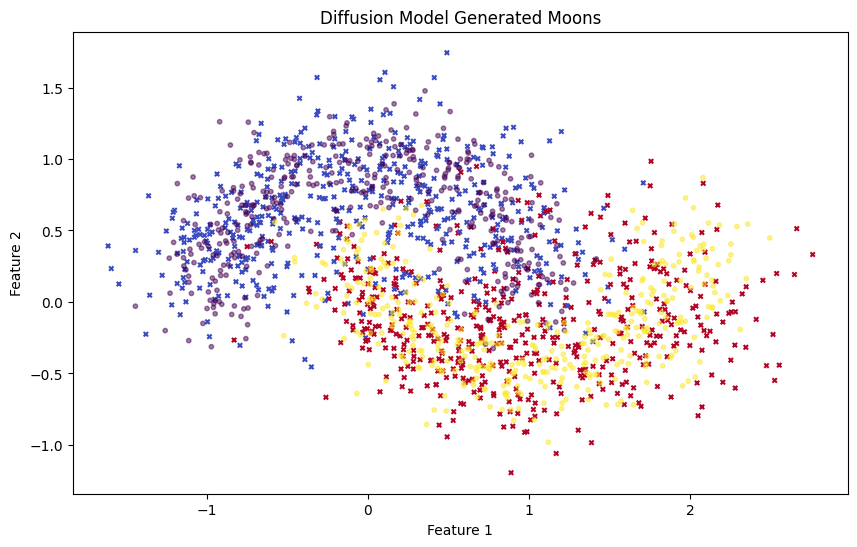

In [93]:
plt.figure(figsize=(10, 6))
plt.scatter(X_gen[:, 0], X_gen[:, 1], s=10, marker="x", cmap='coolwarm', c=y_gen)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.5)
plt.title('Diffusion Model Generated Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [95]:
def update_plot(*args):
    with output:
        output.clear_output(wait=True)
        
        X_gen_chosen = X_gen_samples[num_timesteps - slider_timesteps.value]
        
        fig, ax = plt.subplots(figsize=(10, 6))
        plt.scatter(X_gen_chosen[:, 0], X_gen_chosen[:, 1], s=10, marker="x", cmap='coolwarm', c=y_gen)
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.set_title(f'Generated Moons at timestep {slider_timesteps.value}')
        ax.set_xlim(-2, 3)
        ax.set_ylim(-1.5, 2)
        
        display(fig)
        plt.close(fig)

slider_timesteps = widgets.IntSlider(min=1, max=num_timesteps, step=1, value=num_timesteps, description="Timesteps")
output = widgets.Output()

slider_timesteps.observe(update_plot, names='value')

display(slider_timesteps, output)
update_plot()

IntSlider(value=100, description='Timesteps', min=1)

Output()

> **TODO**: Read about and implement a classifier-free guidance technique.

> <font color="red">**TODO:**</font> Implement VAE and diffusion for MNIST dataset.

## NLP

![](./assets/chatgpt.jpg)

### Dataset

Source: https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [52]:
DATA_PATH = './shakespeare.txt'
with open(DATA_PATH, 'r') as f:
    text = f.read()

In [53]:
text

"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger 

In [54]:
print(f"Length of text: {len(text)} characters")
print(f"\t\t~{len(text.split())} words")
print(f"Number of unique characters: {len(set(text))}")
print(f"Number of unique words: ~{len(set(text.split()))}")


Length of text: 1115394 characters
		~202651 words
Number of unique characters: 65
Number of unique words: ~25670


### Preparation

![](./assets/tokenization.jpg)

> **TODO**: read about byte-pair encoding (BPE) algorithm for tokens selection.

In [55]:
train_frac = 0.9

train_text = text[:int(len(text) * train_frac)]
val_text = text[int(len(text) * train_frac):-1]

In [56]:
tokens = set(train_text)
tokens = sorted(list(tokens))
tokens = ['<sos>', '<unk>'] + tokens
print(f"Vocabulary size: {len(tokens)}")

token2id = {token: i for i, token in enumerate(tokens)}
id2token = {i: token for i, token in enumerate(tokens)}

Vocabulary size: 67


In [57]:
train_ids = [token2id[token] for token in train_text]
val_ids = [token2id[token] for token in val_text]

In [58]:
print(train_ids[:10])
print(train_text[:10])

[20, 49, 58, 59, 60, 3, 17, 49, 60, 49]
First Citi


### Modelling

![](./assets/autoregression.png)

In [59]:
seq_len = 128

In [60]:
train_sequences = [[token2id['<sos>'] for _ in range(seq_len - end)] + train_ids[:end] for end in range(1, seq_len)] + [train_ids[start:start + seq_len] for start in range(len(train_ids) - seq_len)]
val_sequences = [[token2id['<sos>'] for _ in range(seq_len - end)] + val_ids[:end] for end in range(1, seq_len)] + [val_ids[start:start + seq_len] for start in range(len(val_ids) - seq_len)]

train_targets = text[1:int(len(text) * train_frac)+1]
train_targets = [token2id[token] for token in train_targets]

val_targets = text[int(len(text) * train_frac)+1:]
val_targets = [token2id[token] for token in val_targets]

train_sequences = torch.tensor(train_sequences)
val_sequences = torch.tensor(val_sequences)
train_targets = torch.tensor(train_targets)
val_targets = torch.tensor(val_targets)

In [65]:
print(train_ids[:10])
print(train_targets[:10])

[20, 49, 58, 59, 60, 3, 17, 49, 60, 49]
tensor([49, 58, 59, 60,  3, 17, 49, 60, 49, 66])


In [61]:
class LSTMAutoregression(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=3):
        super(LSTMAutoregression, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x, None)
        # x is (batch_size, seq_len, hidden_dim)
        x = x[:, -1, :]
        x = self.fc(x)
        return x

In [62]:
lstm_model = LSTMAutoregression(vocab_size=len(tokens), embedding_dim=32, hidden_dim=128)
lstm_model.train()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
batch_size = 32

In [63]:
len(train_sequences[0]), len(train_sequences[1024])

(128, 128)

In [66]:
train_steps = 10_000
eval_every = 100
train_losses = []
val_losses = []

for step in range(train_steps):
    lstm_model.train()
    optimizer.zero_grad()

    batch_indices = torch.randint(0, len(train_sequences), (batch_size,))
    batch_inputs = train_sequences[batch_indices]
    batch_targets = train_targets[batch_indices]

    outputs = lstm_model(batch_inputs)
    loss = criterion(outputs, batch_targets)
    loss.backward()
    optimizer.step()

    if step % eval_every == 0:
        train_losses.append(loss.item())
        lstm_model.eval()
        with torch.no_grad():
            val_outputs = lstm_model(val_sequences[:100])
            val_loss = criterion(val_outputs, val_targets[:100]).item()
            val_losses.append(val_loss)
            print(f"Step {step}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

Step 0, Train Loss: 4.2068, Val Loss: 4.2003
Step 100, Train Loss: 3.2881, Val Loss: 3.6737
Step 200, Train Loss: 3.4141, Val Loss: 3.6676
Step 300, Train Loss: 2.8962, Val Loss: 3.5253
Step 400, Train Loss: 2.9375, Val Loss: 3.1757
Step 500, Train Loss: 2.6393, Val Loss: 3.0620
Step 600, Train Loss: 3.0563, Val Loss: 3.0287
Step 700, Train Loss: 2.3732, Val Loss: 2.9026
Step 800, Train Loss: 2.9585, Val Loss: 2.9739
Step 900, Train Loss: 2.6387, Val Loss: 2.9085
Step 1000, Train Loss: 2.7345, Val Loss: 2.8755
Step 1100, Train Loss: 2.4789, Val Loss: 2.8839
Step 1200, Train Loss: 1.8386, Val Loss: 2.8525
Step 1300, Train Loss: 2.5123, Val Loss: 2.7992
Step 1400, Train Loss: 2.4619, Val Loss: 2.7486
Step 1500, Train Loss: 2.6447, Val Loss: 2.7874
Step 1600, Train Loss: 2.3126, Val Loss: 2.7376
Step 1700, Train Loss: 2.5988, Val Loss: 2.6966
Step 1800, Train Loss: 1.8360, Val Loss: 2.7171
Step 1900, Train Loss: 2.3654, Val Loss: 2.7318
Step 2000, Train Loss: 2.6619, Val Loss: 2.6719
Step

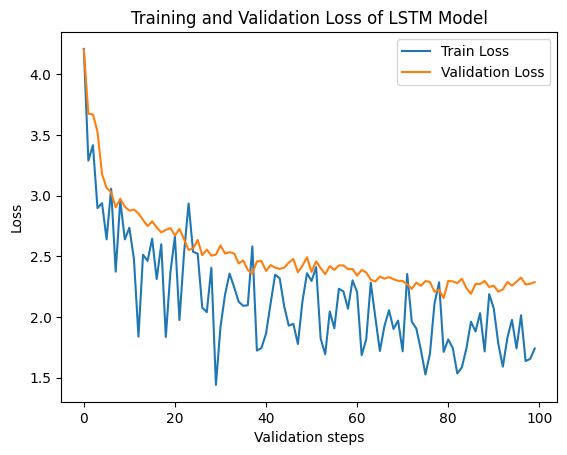

In [67]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Validation steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss of LSTM Model')
plt.show()

#### Greedy search sampling

In [68]:
lstm_model.eval()

desired_len = 100

cur_sequence = [token2id['<sos>']]
for _ in range(desired_len):
    input_tensor = torch.tensor(cur_sequence).unsqueeze(0)
    with torch.no_grad():
        output = lstm_model(input_tensor)
        predicted_token = torch.argmax(output, dim=1).item()
        cur_sequence.append(predicted_token)
    print(id2token[cur_sequence[-1]], end='')
    sleep(0.1)


rone the bear the bear the bear the bear the bear the bear the bear the bear the bear the bear the b

#### Random sampling

In [69]:
lstm_model.eval()

desired_len = 100

cur_sequence = [token2id['<sos>']]
for _ in range(desired_len):
    input_tensor = torch.tensor(cur_sequence).unsqueeze(0)
    with torch.no_grad():
        output = lstm_model(input_tensor)
        probability_distribution = torch.softmax(output, dim=1)
        predicted_token = torch.multinomial(probability_distribution, 1).item()
        cur_sequence.append(predicted_token)
    print(id2token[cur_sequence[-1]], end='')
    sleep(0.1)


&qyeebs?

BOME:
O, stold whith't, Endo he four thid lonch,
But is the this me the erdmines, couls in

#### Top k sampling

In [70]:
lstm_model.eval()

desired_len = 100
top_k = 5

cur_sequence = [token2id['<sos>']]
for _ in range(desired_len):
    input_tensor = torch.tensor(cur_sequence).unsqueeze(0)
    with torch.no_grad():
        output = lstm_model(input_tensor)
        probability_distribution = torch.softmax(output, dim=1)
        # top k sampling
        top_k_samples = torch.topk(probability_distribution, top_k).indices[0]
        top_k_probs = torch.topk(probability_distribution, top_k).values[0]
        top_k_probs = top_k_probs / torch.sum(top_k_probs)

        predicted_token = top_k_samples[torch.multinomial(top_k_probs, 1)].item()
        cur_sequence.append(predicted_token)
    print(id2token[cur_sequence[-1]], end='')
    sleep(0.1)


xzvold:
Had waters be which
In will then worned.

CALUTHUS:
I be see all were to she whing be tell b

> **TODO**: (Read about and) Implement top p sampling and beam search.

## Evaluating generative models

### Frechet distance

Lower (better) if generated and real distributions are similar.

$d^2 = |\mu_X - \mu_Y|^2 + \text{tr}(\Sigma_X + \Sigma_Y - 2(\Sigma_X\Sigma_Y)^{0.5})$

![](./assets/FID.png)

FAD - Frechet Audio Distance

### Inception score

Higher (better) if:
- Images vary;
- Images correspond to model classes.

![](./assets/inception_score.webp)

$\text{IS} = e^{\mathbb{E}_{\mathbf{x}}\text{D}_{\text{KL}}(p(y|\mathbf{x})\|p(y)))}$

$\text{D}_{\text{KL}}(P\|Q) = -\sum_{x\in X}P(x)\log{\frac{Q(x)}{P(x)}}$

![](./assets/kl.webp)

### CLIP score

![](./assets/clip.svg)

### BLEU

**Bilingual Evaluation Understudy Score**

BLEU is a precision focused metric that calculates n-gram overlap of the reference and generated texts. This n-gram overlap means the evaluation scheme is word-position independent apart from n-grams’ term associations. One thing to note in BLEU — there is a brevity penalty i.e. a penalty applied when the generated text is too small compared to the target text.

BLEU's output is always a number between 0 and 1. This value indicates how similar the candidate text is to the reference texts, with values closer to 1 representing more similar texts. Few human translations will attain a score of 1, since this would indicate that the candidate is identical to one of the reference translations. For this reason, it is not necessary to attain a score of 1. Because there are more opportunities to match, adding additional reference translations will increase the BLEU score.

You can check in detail the exact algorithm and equations for implementation [here](https://en.wikipedia.org/wiki/BLEU).

Text and example taken from [here](https://github.com/AntonBazdyrev/iasa_nlp_course/blob/main/Lecture_3/Validation.ipynb).

In [192]:
from nltk.translate.bleu_score import sentence_bleu

# Reference and candidate sentences as lists of words
reference = ['the quick brown fox jumps over the lazy dog']
candidate = 'the fast brown fox jumps over the lazy dog'

# Calculate BLEU score
bleu_score = sentence_bleu([r.split() for r in reference], candidate.split())

print(f'reference: {reference}')
print(f'candidate: {candidate}')
print("BLEU Score:", bleu_score)
print('\n\n')

# Reference and candidate sentences as lists of words
reference = ['the quick brown fox jumps over the lazy dog', 'the fast brown fox jumps over the lazy dog']
candidate = 'the fast brown fox jumps over the lazy dog'

# Calculate BLEU score
bleu_score = sentence_bleu([r.split() for r in reference], candidate.split())

print(f'references: {reference}')
print(f'candidate: {candidate}')
print("BLEU Score:", bleu_score)
print('\n\n')

# Reference and candidate sentences as lists of words
reference = ['the quick brown fox jumps over the lazy dog']
candidate = 'the quick brown fox jumps over the dog'

# Calculate BLEU score
bleu_score = sentence_bleu([r.split() for r in reference], candidate.split())

print(f'references: {reference}')
print(f'candidate: {candidate}')
print("BLEU Score:", bleu_score)
print('\n\n')

# Reference and candidate sentences as lists of words
reference = ['the quick brown fox jumps over the lazy dog']
candidate = 'fox jumps over the dog'

# Calculate BLEU score
bleu_score = sentence_bleu([r.split() for r in reference], candidate.split())

print(f'references: {reference}')
print(f'candidate: {candidate}')
print("BLEU Score:", bleu_score)
print('\n\n')

# Reference and candidate sentences as lists of words
reference = ['the quick brown fox jumps over the lazy dog']
candidate = 'dog jumps the fox lazy'

# Calculate BLEU score
bleu_score = sentence_bleu([r.split() for r in reference], candidate.split())

print(f'references: {reference}')
print(f'candidate: {candidate}')
print("BLEU Score:", bleu_score)
print('\n\n')

# Reference and candidate sentences as lists of words
reference = ['the quick brown fox jumps over the lazy dog']
candidate = 'absolutely random sentence here'

# Calculate BLEU score
bleu_score = sentence_bleu([r.split() for r in reference], candidate.split())

print(f'references: {reference}')
print(f'candidate: {candidate}')
print("BLEU Score:", bleu_score)

reference: ['the quick brown fox jumps over the lazy dog']
candidate: the fast brown fox jumps over the lazy dog
BLEU Score: 0.7506238537503395



references: ['the quick brown fox jumps over the lazy dog', 'the fast brown fox jumps over the lazy dog']
candidate: the fast brown fox jumps over the lazy dog
BLEU Score: 1.0



references: ['the quick brown fox jumps over the lazy dog']
candidate: the quick brown fox jumps over the dog
BLEU Score: 0.767279645960659



references: ['the quick brown fox jumps over the lazy dog']
candidate: fox jumps over the dog
BLEU Score: 0.31772355751081427



references: ['the quick brown fox jumps over the lazy dog']
candidate: dog jumps the fox lazy
BLEU Score: 8.186018806130924e-232



references: ['the quick brown fox jumps over the lazy dog']
candidate: absolutely random sentence here
BLEU Score: 0


> <font color='red'>**TODO**</font>: Implement FID, IS and BLEU. Use them for evalauation of the models above.